In [409]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import time


In [410]:
# sorting data from a file
datapath = "output/eye_data.csv"

# convert to dataframe
import pandas as pd
df = pd.read_csv(datapath)

df.head()

# open the output fodler and read all of the files

# create a list of all the image files
# and their labels
image_numbers = df['frame_idx'].tolist()
# load image
print("image_numbers", image_numbers[-1])

images = []
coords = []
for idx, row in df.iterrows():
    frame_num = int(row['frame_idx'])
    image_path = f"output/{frame_num}.png"
    image = cv2.imread(image_path)
    if image is None:
        continue
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # resize the image to 128x128
    image = cv2.resize(image, (128, 128))
    images.append(image)
    h = row['h']
    scale = 128/h
    a = row['ellipse_angle']
    a_norm = (((a + 90) % 180) - 90)/90
    df.at[idx, 'ellipse_x'] *= scale
    df.at[idx, 'ellipse_y'] *= scale
    df.at[idx, 'ellipse_h'] *= scale/2
    df.at[idx, 'ellipse_w'] *= scale/2
    df.at[idx, 'h'] *= scale
    df.at[idx, 'w'] *= scale
    df.at[idx, 'ellipse_angle'] = a_norm
    point = ((row['ellipse_x'] * scale, 
               row['ellipse_y'] * scale, 
               row['ellipse_w'] * scale/2, 
               row['ellipse_h'] * scale/2, 
               a_norm))
    coords.append((row['ellipse_x'] * scale, row['ellipse_y'] * scale, 
                   row['ellipse_w'] * scale/2, row['ellipse_h'] * scale/2, a_norm
                     ))



image_numbers 677


C:\Users\NateLy\AppData\Local\Temp\ipykernel_27220\2781306397.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.99999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'h'] *= scale
C:\Users\NateLy\AppData\Local\Temp\ipykernel_27220\2781306397.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.99999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'w'] *= scale


In [411]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, coords, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype=np.float32) / 255.0
X_test  = np.array(X_test, dtype=np.float32) / 255.0
y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test, dtype=np.float32)

def build_model():
    model = models.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(5) 
    ])
    return model

model = build_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)
model.summary()




Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_175 (Conv2D)             │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_175               │ (None, 63, 63, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_176               │ (None, 30, 30, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_177 (Conv2D)             │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_177               │ (None, 14, 14, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_56 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,701 (6.22 MB)

 Trainable params: 1,629,701 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [412]:
print("x shape", X_train.shape, "y shape", y_train.shape)

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")

start = time.time()

preds = model.predict(X_test[:100])
end = time.time()
print(f"Predictions per second: {100 / (end - start):.2f}")
# print("Predicted coords:", preds)
# print("Actual coords:", y_test[:100])

# find mean absolute error for the x and y coordinates



x shape (487, 128, 128) y shape (487, 5)
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 1790.4457 - mae: 34.2516 - val_loss: 1725.8342 - val_mae: 33.7651
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1738.1593 - mae: 33.7494 - val_loss: 1635.1709 - val_mae: 32.9473
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1653.1476 - mae: 33.0830 - val_loss: 1488.0054 - val_mae: 31.5993
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1477.5953 - mae: 31.3711 - val_loss: 1252.2146 - val_mae: 29.2075
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1223.5636 - mae: 28.7136 - val_loss: 901.2359 - val_mae: 24.9948
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 833.1625 - mae: 23.8536 - val_loss: 461.0230 - val_mae: 18.0763
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 395.5604 - mae: 16.2529 - val_loss: 104.8673 - val_mae: 7.9351
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 109.6661 - mae: 7.3929 - val_loss: 81.

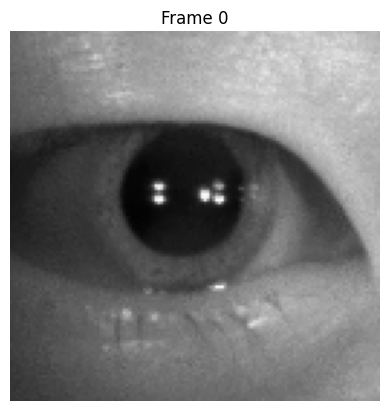

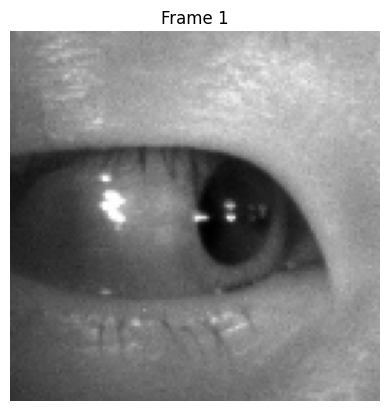

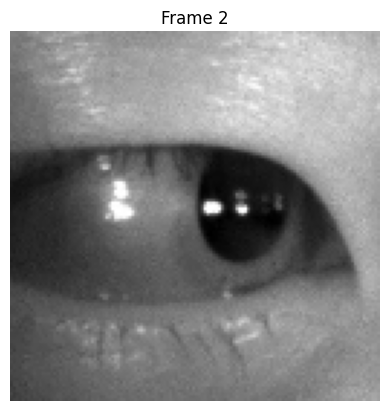

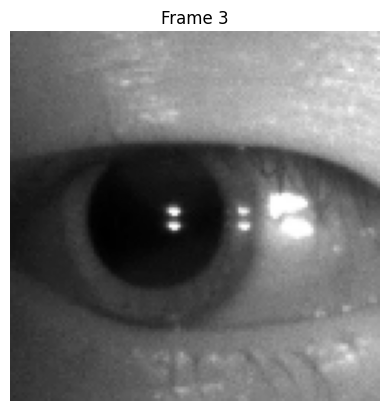

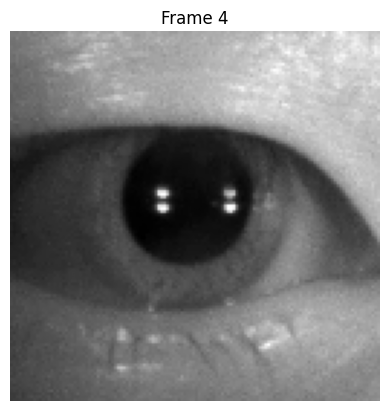

In [413]:
# plot images with elipses and centers of actual vs predicted
for i in range(5):
    image = X_test[i].reshape(128, 128)
    # convert to grayscale
    entry = y_test[i]
    pred = preds[i]

    ellipse_x = int(entry[0])
    ellipse_y = int(entry[1])
    ellipse_w = int(entry[2])
    ellipse_h = int(entry[3])
    ellipse_angle = entry[4]

    pred_x = int(pred[0])
    pred_y = int(pred[1])
    pred_w = int(pred[2])
    pred_h = int(pred[3])
    pred_angle = pred[4]
    actual_color = (100, 100, 0)
    pred_color = (255, 255, 255)

    plt.imshow(image, cmap='gray')
    plt.title(f"Frame {i}")
    cv2.ellipse(image, (ellipse_x, ellipse_y), (ellipse_w, ellipse_h), ellipse_angle, 0, 360, actual_color, 1)
    cv2.circle(image, (ellipse_x, ellipse_y), 1, actual_color, -1)

    cv2.ellipse(image, (pred_x, pred_y), (pred_w, pred_h), pred_angle, 0, 360, pred_color, 1)
    cv2.circle(image, (pred_x, pred_y), 1, pred_color, -1)

    plt.axis('off')
    plt.show()
    


In [414]:
# save CNN
model.save("eye_tracking_model.keras", include_optimizer=False)
model = tf.keras.models.load_model("eye_tracking_model.keras")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open("eye_tracking_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmpbcwgq08c\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmpbcwgq08c\assets


Saved artifact at 'C:\Users\NateLy\AppData\Local\Temp\tmpbcwgq08c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_layer_59')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2942658721952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942265069056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2943050152624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2943050145056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2943050139952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2943245442512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2943245446208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942204460752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942204449136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942100802544: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [415]:
model = tf.keras.models.load_model("eye_tracking_model.keras")

# make predictions on a single image
test_image = X_test[0].reshape(1, 128, 128, 1)
predicted_coords = model.predict(test_image)
print("Predicted coordinates:", predicted_coords)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted coordinates: [[3030.788   2912.5588   592.24774  833.0916  -165.68369]]
